# One-class SVM
One-class SVM is a Support Vector Machine used for unsupervised learning, it is called One-class as it will classify the data into a single classification cluster, thereby finding any outliers/anomalies by the data points not covered within the single classification cluster (also referred to as novelty detection).

### Inspecting the data
One-class SVM, as a form of Support Vector machine, utilizes the differences between features to classify the data points. This can be represented for example in a scatter plot by the distance between different points.

For this project, we want to find malicious network requests from networking logs, thereby having the benign data be classified and the malicious data become outliers.

As a prerequisite to this data inspection, it is highly recommended to view the EDA notebook done for this project (this can be found in the [sueAI repository](https://github.com/Fowthy/SueAI))

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/elastic_february2022_data.csv')

Lets take a quick look at the general data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398414 entries, 0 to 398413
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   _source_flow_id            398414 non-null  object 
 1   _source_flow_final         398414 non-null  bool   
 2   _source_source_ip          398414 non-null  object 
 3   _source_destination_ip     398414 non-null  object 
 4   _source_network_bytes      398414 non-null  int64  
 5   _source_network_transport  396080 non-null  object 
 6   _source_@timestamp         398414 non-null  object 
 7   _source_event_duration     398414 non-null  int64  
 8   _source_destination_port   395857 non-null  float64
 9   _source_source_port        395857 non-null  float64
 10  label                      398414 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 30.8+ MB


In [5]:
df.head(5)

,_source_flow_id,_source_flow_final,_source_source_ip,_source_destination_ip,_source_network_bytes,_source_network_transport,_source_@timestamp,_source_event_duration,_source_destination_port,_source_source_port,label
0,EAD/////AP////////8AAAGsEAILrBACDA,False,240.16.203.232,240.16.203.236,72096053,NaN,2022-02-25T12:20:00.007Z,41753051589,NaN,NaN,benign
1,EAD/////AP////////8AAAGsEAIKrBACDA,False,240.16.203.236,240.16.203.233,913734,NaN,2022-02-25T12:20:00.007Z,35268442180,NaN,NaN,benign
2,EAT/////AP//////CP8AAAHAqFSDwKj3AAEIbQI,False,190.215.171.30,190.215.9.27,30684984,tcp,2022-02-25T12:20:00.007Z,41662926223,621.0,2049.0,benign
3,EAT/////AP//////CP8AAAHAqFSPwKj3D8CeVCQ,False,190.215.171.17,190.215.9.16,220136,tcp,2022-02-25T12:20:00.007Z,41154340691,9300.0,40640.0,benign
4,EAT/////AP//////CP8AAAEKapNUwKj3DvAjvpo,False,190.215.9.17,53.181.234.140,73242,tcp,2022-02-25T12:20:00.007Z,41259502779,9200.0,39614.0,benign


In [4]:
df.tail(5)


,_source_flow_id,_source_flow_final,_source_source_ip,_source_destination_ip,_source_network_bytes,_source_network_transport,_source_@timestamp,_source_event_duration,_source_destination_port,_source_source_port,label
398409,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,True,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,23101,9099.0,51980.0,benign
398410,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,18591,9099.0,52008.0,benign
398411,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,19850,9099.0,52024.0,benign
398412,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,35017,9099.0,52040.0,benign
398413,QAT///////8A////IP8AAAEAAAAAAAAAAAAAAAAAAAABAA...,False,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,3fff:3018:1e0:f80f:fff8:fbf0:3cf7:fdd7,172,tcp,2022-02-25T14:09:20.009Z,33292,9099.0,52070.0,benign


To get started, as the One-class SVM will create a single classification with the rest outliers, lets create one hot encoded feature called outlier that will show the malicious points, as the model should show these as outliers.

In [3]:
df['outlier'] = df['label'].apply(lambda x: 1 if x == 'malicious' else 0)

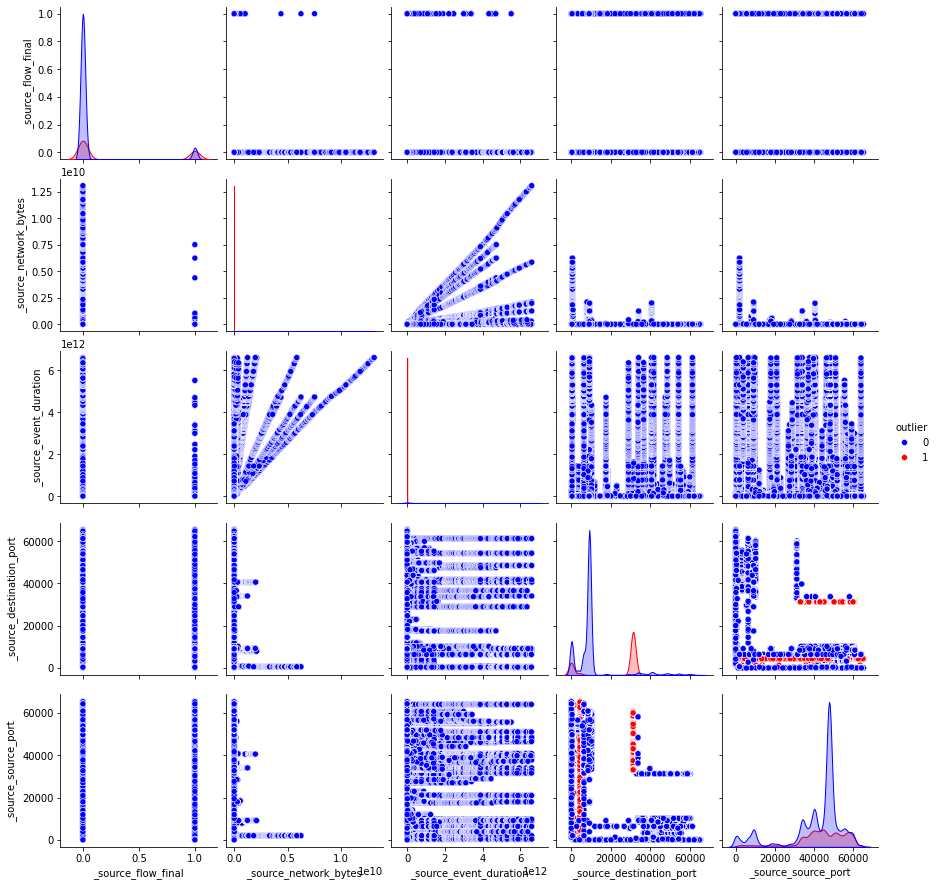

In [21]:
sns.pairplot(df[['_source_flow_final', '_source_network_bytes', '_source_event_duration', '_source_destination_port', '_source_source_port', 'outlier']], diag_kind="kde", hue="outlier", palette={0: "blue", 1: "red"})

Above I have created a pairplot, of the different numerical features plotted against one another, with the benign data in blue and the malicious data in red.  
Diagonally, an estimate is shown of the kernal density, this can give an idea of the distribution of a feature over the range found of all the data points (e.g. if the feature has evenly distributed data points it should look like a normal distribution).

The numerical feature (which isn't really numerical, as it has no relation to the number scale) is the _source_destination_port, this feature records where the networking request went to when communicating with the cluster.  
The _source_destination_port shows a clear jump in occurences somewhere around ~30000 while the benign frequency stays low, which would be perfect for anomaly detection.  
However, it should be kept in mind that this data was collected in an experiment/research setting and all malicious data collected is not only simulated but could also be specific to the experiment environment, as between clusters/deployments or even between different kinds of attacks (this dataset only had a few different kinds of attacks) the destination port could change.

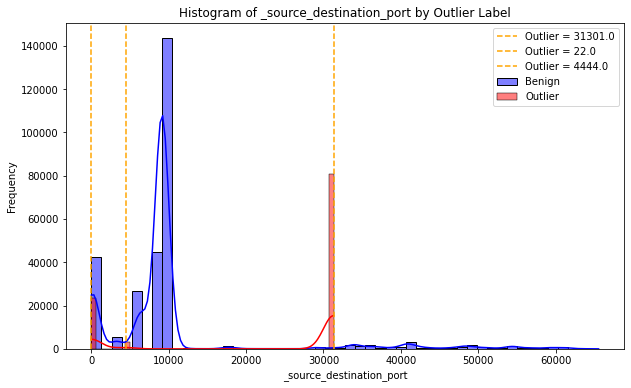

In [35]:
# Filter the data for "outlier" equals 0 and 1
benign_data = df[df['outlier'] == 0]['_source_destination_port']
outlier_data = df[df['outlier'] == 1]['_source_destination_port']

common_bins = 50

# Create the histograms for both categories
plt.figure(figsize=(10, 6))

sns.histplot(benign_data, kde=True, label="Benign", color='blue', bins=common_bins)
sns.histplot(outlier_data, kde=True, label="Outlier", color='red', bins=common_bins)

# Get indicators for places where outliers are noticeably higher than benign
outlier_counts = outlier_data.value_counts()
outlier_ports = outlier_counts[outlier_counts > 1000].index.tolist()
for outlier_port in outlier_ports:
    plt.axvline(outlier_port, color='orange', linestyle='--', label=f"Outlier = {outlier_port}")

plt.title('Histogram of _source_destination_port by Outlier Label')
plt.xlabel('_source_destination_port')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Above is a histogram of the distribution of benign vs outlier data for the _source_destination_port, here three noticeable outliers were found (>1000 requests more of outliers than benign)

Now lets start looking for other features to use, that might not be immediately visible in the data

Firstly, lets create a reusable histogram function to easily display histograms like the one above for _source_destination_port

In [26]:
def Histogram(df, feature, title, maxRange=None, outlierMargin=1000, includeOutlierLine=True):
    # Filter the data for "outlier" equals 0 and 1
    benign_data = df[df['outlier'] == 0][feature]
    outlier_data = df[df['outlier'] == 1][feature]

    if maxRange is not None:
            benign_data = benign_data[benign_data <= maxRange]
            outlier_data = outlier_data[outlier_data <= maxRange]
    common_bins = 50

    # Create the histograms for both categories
    plt.figure(figsize=(10, 6))

    sns.histplot(benign_data, kde=True, label="Benign", color='blue', bins=common_bins)
    sns.histplot(outlier_data, kde=True, label="Malicious", color='red', bins=common_bins)

    if includeOutlierLine:
        # Get indicators for places where outliers are noticeably higher than benign
        outlier_counts = outlier_data.value_counts()
        outlier_ports = outlier_counts[outlier_counts > outlierMargin].index.tolist()
        for outlier_port in outlier_ports:
            plt.axvline(outlier_port, color='orange', linestyle='--', label=f"Malicious = {outlier_port}")

    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

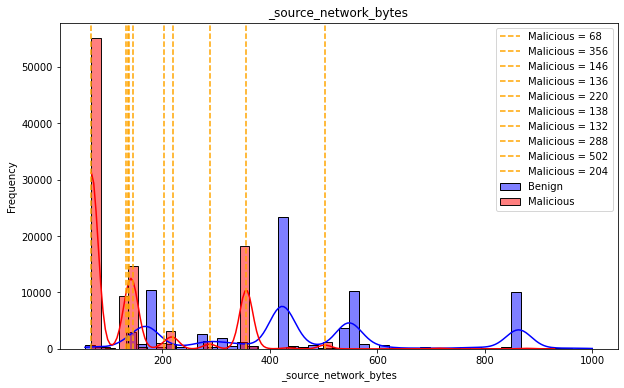

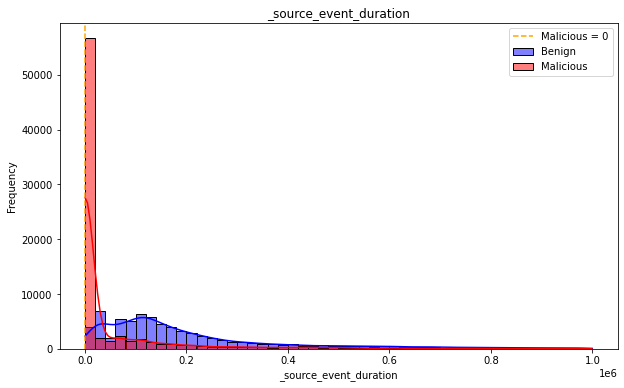

In [24]:
Histogram(df, "_source_network_bytes", "_source_network_bytes", 1000)
Histogram(df, "_source_event_duration", "_source_event_duration", 1000000)

There are clearly more malicious requests sent with lower network bytes and duration time. This would make sense, as generally network attacks such as DDoS attacks rely on large amount of small traffic being sent over a single port.

In [16]:
print("benign records:", df[df['label'] == 'benign']['label'].count())
print("malicious records:", df[df['label'] == 'malicious']['label'].count())

benign records: 291169
malicious records: 107245


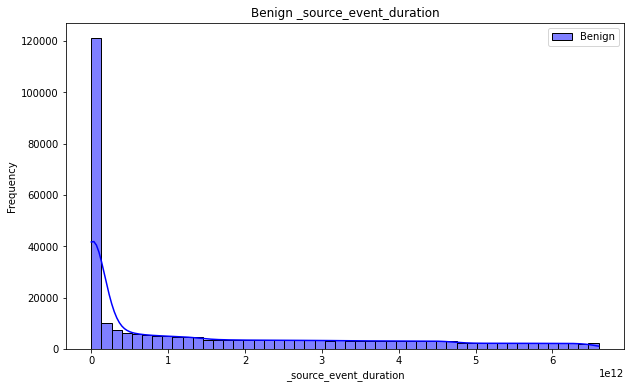

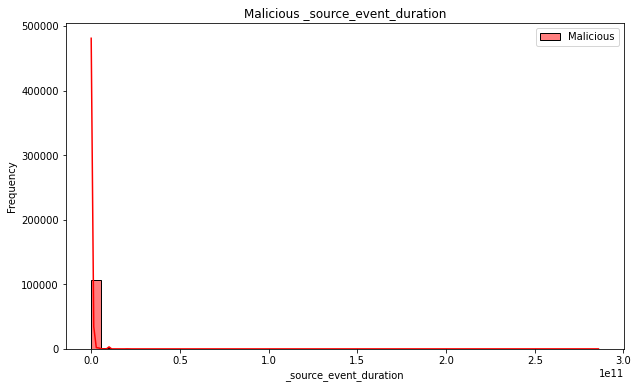

In [27]:
Histogram(df[df['outlier'] == False], "_source_event_duration", "Benign _source_event_duration", includeOutlierLine=False)
Histogram(df[df['outlier'] == True], "_source_event_duration", "Malicious _source_event_duration", includeOutlierLine=False)

Looking above, it is visible, that while both benign and malicious data seem to have a large amount of records around the lower range of duration, the Malicious data is significantly more squashed against the lower bounds

Let's put the _source_event_duration on a logarithmic scale to see what happens

In [28]:
df['_source_event_duration_log'] = df['_source_event_duration'].apply(lambda x: np.log(x) if x > 0 else 0)

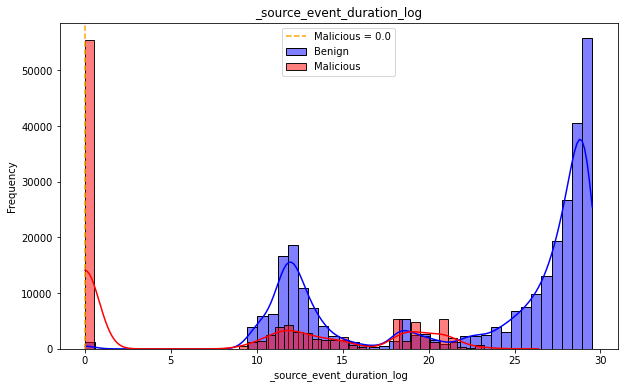

In [29]:
Histogram(df, "_source_event_duration_log", "_source_event_duration_log")

Looking at the logged data, it is definitely more spread out and shows much clearer possible differences between malicious and benign data, however now a lot of the benign data seems to be bunched up around the end which could cause possible issues as we are reducing the amount of detail here (this might be fine for our usecase however, as there seems to be very little to no malicious data within this range anyway)

Maybe choosing a smaller root would be better, to keep more detail as done below

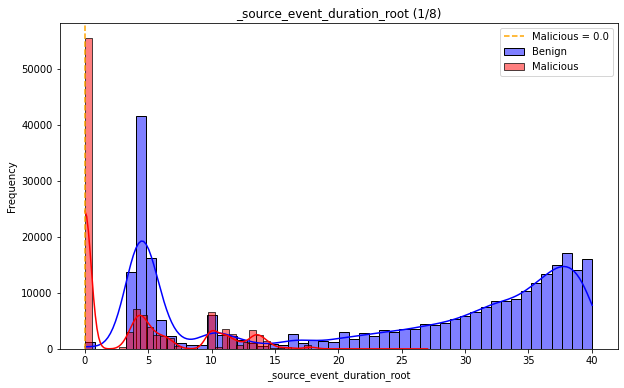

In [39]:
df['_source_event_duration_root'] = df['_source_event_duration'].apply(lambda x: x ** (1/8) if x > 0 else 0)
Histogram(df, "_source_event_duration_root", "_source_event_duration_root (1/8)")

Doing the same to _source_network_bytes, seems to not give as usefull results as putting it on a logarithmic scale does not show any new data. Malicious data is still very much dominant around the <5 (log) bytes with benign data being a lot better spread out across the board

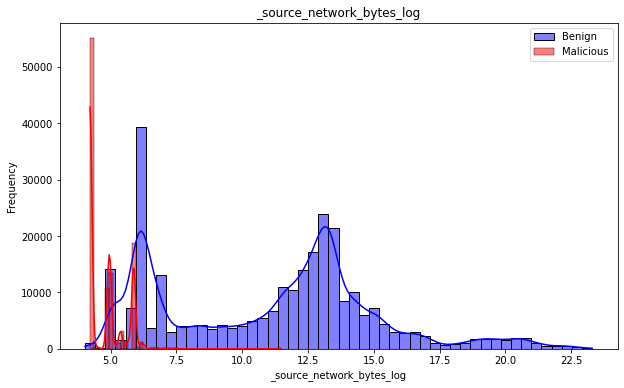

In [41]:
df['_source_network_bytes_log'] = df['_source_network_bytes'].apply(lambda x: np.log(x) if x > 0 else 0)
Histogram(df, "_source_network_bytes_log", "_source_network_bytes_log", includeOutlierLine=False)

Lets plot these features against eachother

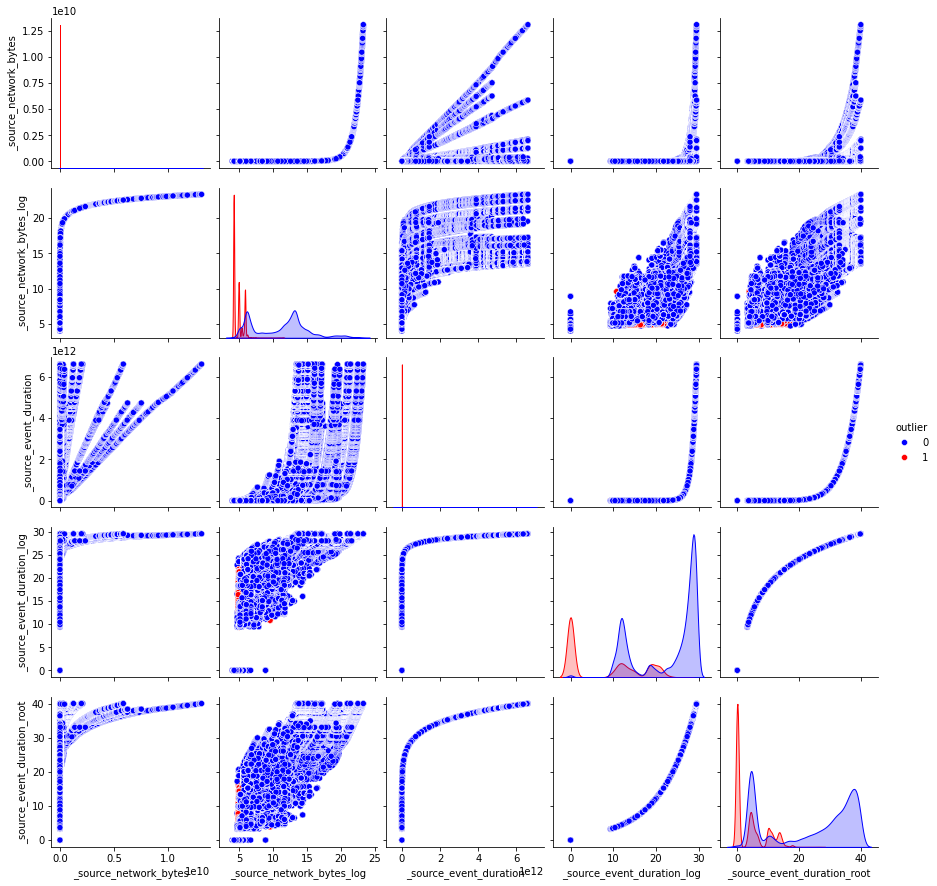

In [45]:
sns.pairplot(df[['_source_network_bytes', '_source_network_bytes_log', '_source_event_duration', '_source_event_duration_log', '_source_event_duration_root', 'outlier']], diag_kind="kde", hue="outlier", palette={0: "blue", 1: "red"})

There are still not direct correlations that could be made between the features, which for OneClassSVM does not have to be bad as it actually relies on finding outlier data that does not conform to the 'norm' such as with the network_bytes and duration

Another idea that has been discussed, is that time might actually be very important for finding the malicious data, as being able to see how network traffic is behaving over a set period of time might indicate how an application is interacted with (normally, or maliciously), this is reinforced by the fact that the [research paper]() this dataset originates from used probabilistic state machine which took into acount not only a single record, but data over a period of time and achieved fairly good results.

In [49]:
df[['_source_flow_id', '_source_flow_final', '_source_source_ip', '_source_destination_ip', '_source_@timestamp']].head()

,_source_flow_id,_source_flow_final,_source_source_ip,_source_destination_ip,_source_@timestamp
0,EAD/////AP////////8AAAGsEAILrBACDA,False,240.16.203.232,240.16.203.236,2022-02-25T12:20:00.007Z
1,EAD/////AP////////8AAAGsEAIKrBACDA,False,240.16.203.236,240.16.203.233,2022-02-25T12:20:00.007Z
2,EAT/////AP//////CP8AAAHAqFSDwKj3AAEIbQI,False,190.215.171.30,190.215.9.27,2022-02-25T12:20:00.007Z
3,EAT/////AP//////CP8AAAHAqFSPwKj3D8CeVCQ,False,190.215.171.17,190.215.9.16,2022-02-25T12:20:00.007Z
4,EAT/////AP//////CP8AAAEKapNUwKj3DvAjvpo,False,190.215.9.17,53.181.234.140,2022-02-25T12:20:00.007Z


The dataset contains _source_flow info, here the _source_flow_id indicates what records are part of the same "flow" or "session", with the _source_flow_final indicating the last request sent, normally this id would contain usefull information as part of its structure, however this has been anonymized in this dataset

In [77]:
df[df['_source_flow_id'] == 'EAD/////AP////////8AAAGsEAILrBACDA'][['_source_flow_final', '_source_source_ip', '_source_destination_ip', '_source_@timestamp']].sort_values(by='_source_@timestamp', ascending=False).head()

,_source_flow_final,_source_source_ip,_source_destination_ip,_source_@timestamp
398336,False,240.16.203.236,240.16.203.232,2022-02-25T14:09:20.294Z
398008,False,240.16.203.232,240.16.203.236,2022-02-25T14:09:20.009Z
397934,False,240.16.203.236,240.16.203.232,2022-02-25T14:09:10.096Z
397633,False,240.16.203.232,240.16.203.236,2022-02-25T14:09:10.009Z
397477,False,240.16.203.236,240.16.203.232,2022-02-25T14:09:00.094Z


Looking at a specific source flow, it can be seen that multiple _source_flow_finals can be true, as a flow can consist of multiple connections, this will generally happen when multiple endpoint connections occur within a single flow, as would be the case above with:   
240.16.203.232 -> 240.16.203.236  
&  
240.16.203.236 -> 240.16.203.232

Lets see how many flows are within this dataset

In [65]:
print("unique flows: ", df['_source_flow_id'].nunique())

unique flows:  47382


Lets squash all flow records together, keeping the same flows with different source/destination ips seperated

In [172]:
# First clear out the NaN values for the columns that will be used to squash records
flow_df = df.dropna(subset=['_source_flow_id', '_source_source_ip', '_source_destination_ip'])
# Convert the timestamp column to datetime type
flow_df['_source_@timestamp'] = pd.to_datetime(flow_df['_source_@timestamp'])
# Add any new column for the amount of packets
flow_df['packets'] = np.ones(len(flow_df))
# byte information for finding deviation
flow_df['min_network_bytes'] = flow_df['_source_network_bytes']
flow_df['max_network_bytes'] = flow_df['_source_network_bytes']
# duration information for finding deviation
flow_df['min_source_event_duration'] = flow_df['_source_event_duration']
flow_df['max_source_event_duration'] = flow_df['_source_event_duration']
# timestamp information for finding deviation
flow_df['min_source_@timestamp'] = flow_df['_source_@timestamp']
flow_df['max_source_@timestamp'] = flow_df['_source_@timestamp']
# Squash the records
flow_df = flow_df.sort_values(by='_source_@timestamp', ascending=False).groupby(['_source_flow_id', '_source_source_ip', '_source_destination_ip'])

squash_rules = {
    '_source_event_duration': 'sum',
    '_source_network_bytes': 'sum',
    '_source_@timestamp': 'mean',
    'packets': 'sum',
    'label': 'first',
    'outlier': 'first',
    # Later addition for finding the deviation of byte data
    'min_network_bytes': 'min',
    'max_network_bytes': 'max',
    # Later addition for finding the deviation of event duration
    'min_source_event_duration': 'min',
    'max_source_event_duration': 'max',
    # Later addition for finding the deviation of timestamp
    'min_source_@timestamp': 'min',
    'max_source_@timestamp': 'max'
}

flow_df = flow_df.agg(squash_rules).reset_index()

In [171]:
flow_df[['_source_flow_id', '_source_source_ip', '_source_destination_ip', '_source_event_duration', '_source_network_bytes', '_source_@timestamp', 'packets', 'label']].head()

,_source_flow_id,_source_source_ip,_source_destination_ip,_source_event_duration,_source_network_bytes,_source_@timestamp,packets,label
0,EAD/////AP////////8AAAEKAAICCgACDw,53.255.61.226,53.255.61.238,249433130798,4104,2022-02-25 13:43:17.241209088+00:00,43.0,benign
1,EAD/////AP////////8AAAEKAAICwKhUlg,53.255.61.226,190.215.171.0,249432742425,3528,2022-02-25 13:47:34.906846208+00:00,39.0,benign
2,EAD/////AP////////8AAAEKAAICwKhUlw,53.255.61.226,190.215.171.1,84840,576,2022-02-25 13:01:25.001249792+00:00,4.0,benign
3,EAD/////AP////////8AAAEKAAIPwKhUkw,53.255.61.238,190.215.171.5,219948214601,17680,2022-02-25 13:52:00.065333248+00:00,9.0,benign
4,EAD/////AP////////8AAAEKAAIPwKj3EQ,53.255.61.238,190.215.9.2,160358428863,16640,2022-02-25 13:51:50.003285760+00:00,7.0,benign


Now the records have been squashed into per flow (unique source->destination -ip) for this:
- The event_duration has been summed, as well as the network_bytes
- The mean timestamp has been taken
- The amount of squashed packets has been counted
- The label has been brought along

In [128]:
print("Bening records: ", len(flow_df[flow_df['label'] == 'benign']), f" (mean packets: {flow_df[flow_df['label'] == 'benign']['packets'].mean()})")
print("Malicious records: ", len(flow_df[flow_df['label'] == 'malicious']), f" (mean packets: {flow_df[flow_df['label'] == 'malicious']['packets'].mean()})")

Bening records:  19508  (mean packets: 14.925620258355547)
Malicious records:  28211  (mean packets: 3.8015313175711603)


Now the dataset actually contains more malicious records than benign records, which makes sense when looking at the mean packets that have been merged together.  
malicious records clearly sent less packets per flow, which aligns with out previous ideas 

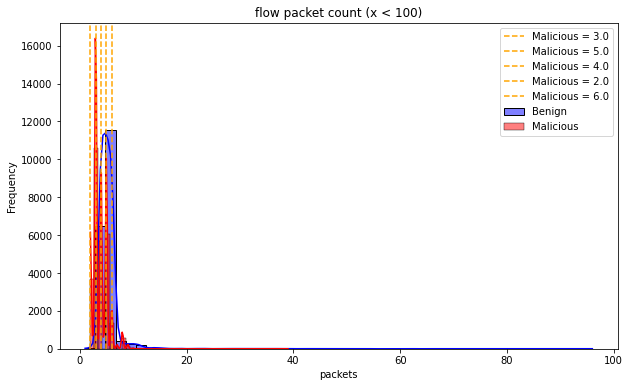

In [146]:
Histogram(flow_df, "packets", "flow packet count (x < 100)", maxRange=100)

the packets features seems to have some clear outliers, so lets put it logarithmically

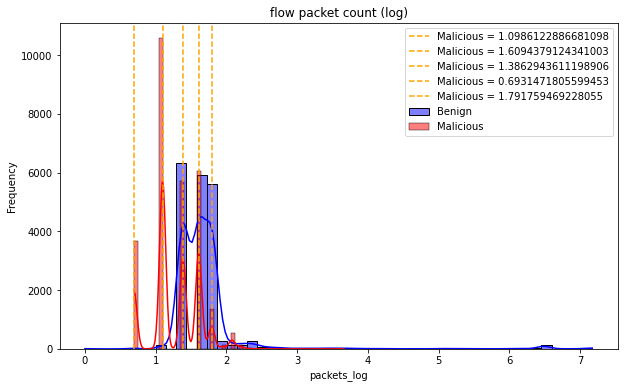

In [139]:
flow_df['packets_log'] = flow_df['packets'].apply(lambda x: np.log(x) if x > 0 else 0)
Histogram(flow_df, "packets_log", "flow packet count (log)")

Putting it logarithmically, definetly does give some more insights, however the conclusion seems to be the same, that being that yes malicious flows often send less packages and might be valuable for OneClassSVM, but can not be used as the only feature as there are still benign flows within this range however few (and there are also malicious flows in the higher scale together with most benign data)

Next lets look at the merged networking duration and bytes

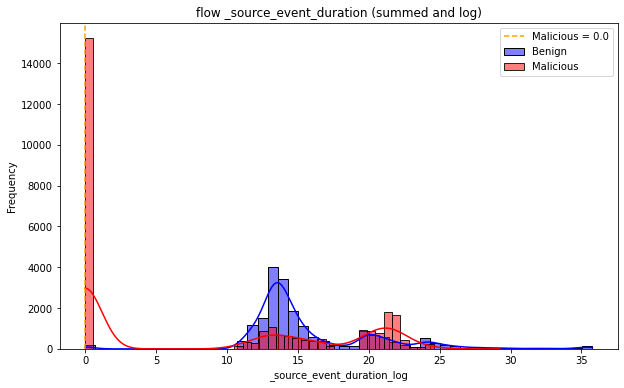

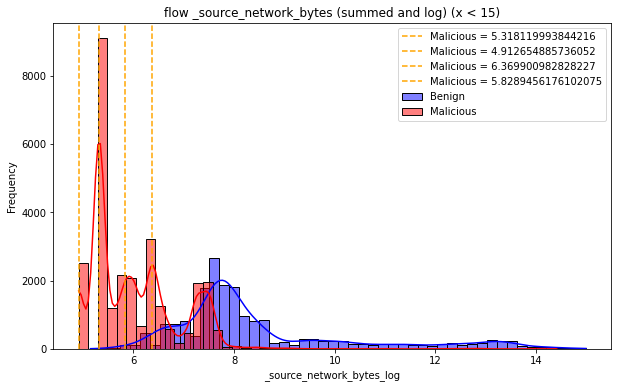

In [145]:
flow_df['_source_event_duration_log'] = flow_df['_source_event_duration'].apply(lambda x: np.log(x) if x > 0 else 0)
Histogram(flow_df, "_source_event_duration_log", "flow _source_event_duration (summed and log)")
flow_df['_source_network_bytes_log'] = flow_df['_source_network_bytes'].apply(lambda x: np.log(x) if x > 0 else 0)
Histogram(flow_df, "_source_network_bytes_log", "flow _source_network_bytes (summed and log) (x < 15)", maxRange=15, outlierMargin=2000)

Again, the same findings as with the per packets exploration, however it is a bit more distinct now with event_duration and network_bytes benign vs malicious split 

Out of interest it might also be interesting to explore the average bytes per flow, however this will most likely show similar results as the none flow data as we are effectively reducing the bytes back to their pre-squash amount, effectively undersampling the data

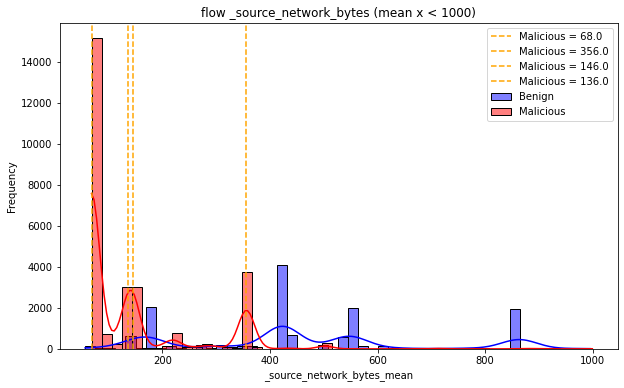

In [149]:
flow_df['_source_network_bytes_mean'] = flow_df['_source_network_bytes'] / flow_df['packets']
Histogram(flow_df, "_source_network_bytes_mean", "flow _source_network_bytes (mean x < 1000)", maxRange=1000)

Excluding benign outliers, the mean bytes actually has quite clear malicious vs benign amounts which is very interesting, perhaps the deviation would also be interesting to consider

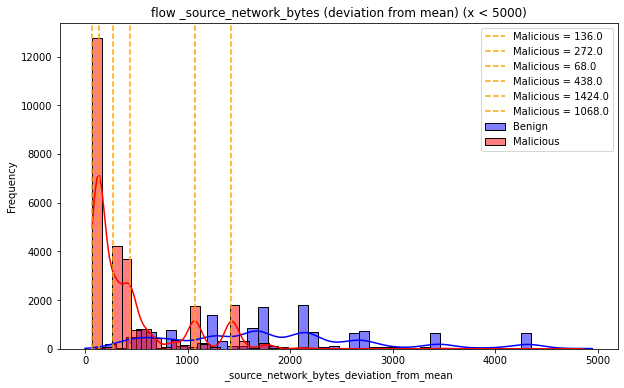

In [153]:
flow_df['_source_network_bytes_deviation_from_mean'] = flow_df['_source_network_bytes'] - (flow_df['min_network_bytes'] + flow_df['max_network_bytes']) / 2
Histogram(flow_df, "_source_network_bytes_deviation_from_mean", "flow _source_network_bytes (deviation from mean) (x < 5000)", maxRange=5000)

While interesting, it shows similar results as just looking at the mean

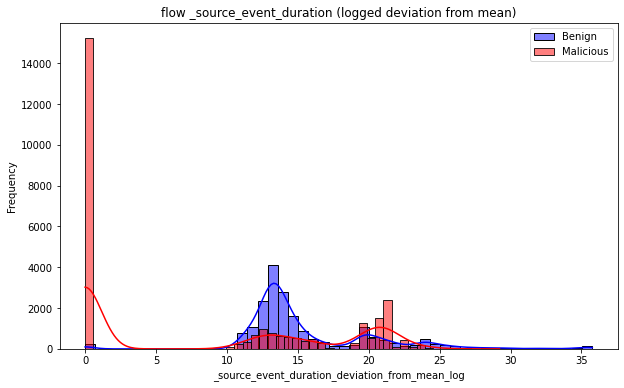

In [162]:
flow_df['_source_event_duration_deviation_from_mean'] = flow_df['_source_event_duration'] - (flow_df['min_source_event_duration'] + flow_df['max_source_event_duration']) / 2
flow_df['_source_event_duration_deviation_from_mean_log'] = flow_df['_source_event_duration_deviation_from_mean'].apply(lambda x: np.log(x) if x > 0 else 0)
Histogram(flow_df, "_source_event_duration_deviation_from_mean_log", "flow _source_event_duration (logged deviation from mean)", includeOutlierLine=False)

Putting this deviation on a logarithmic scale, and ignoring the values at 0, as these records only had a single packet sent, there is an interesting difference with benign generally having a smaller deviation than malicious while still having a significant amount of overlap.  
I however, expected the deviation to show more malicious records on the lower end as these requests are often made automatically with very reproduceable request structure, but it is infact the opposite, benign users seem to generally have the same amount of duration, this might be due to the packet duration not actually being equivalent to the duration a user spents on an action but instead the networking time the packet took from source to destination

So lets actually look at the timestamp info for the packets then, as this might give more insight into the length of a flow session

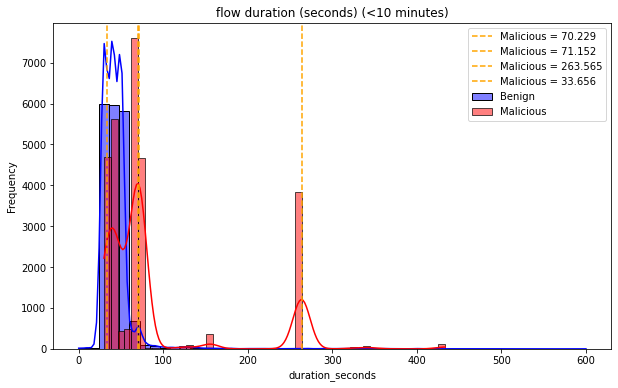

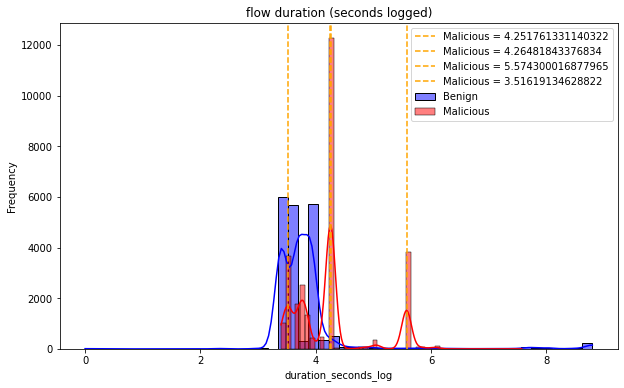

In [185]:
flow_df['duration'] = flow_df['max_source_@timestamp'] - flow_df['min_source_@timestamp']
flow_df['duration_seconds'] = flow_df['duration'].dt.total_seconds()
flow_df['duration_seconds_log'] = flow_df['duration_seconds'].apply(lambda x: np.log(x) if x > 0 else 0)

Histogram(flow_df, "duration_seconds", "flow duration (seconds) (<10 minutes)", outlierMargin=3000, maxRange=600)

Histogram(flow_df, "duration_seconds_log", "flow duration (seconds logged)", outlierMargin=3000)

For the graph above, the duration of a flow was calculated using the max - min timestamp, and was then converted to seconds.  
To include any outliers, the data was then also shown on a logarithmic scale as well as the first graph which shows any flows that lasted less than 10 minutes.  

However, it once again does not show what was initially expected, as initially it was thought that malicious flows would be very short with low byte amounts, but here it actually seems that there are spikes in the higher range of duration, beyond the benign. This would align with the other kinds of attacks that were done to create this dataset however, where people manually tried to hack into an SSH service and add a bitcoin miner, and people trying to access hidden files on the server.

Another way to approach this, could be to instead squash to data based on a certain timeframe (such as 20 seconds) instead of per flow/session, as for the scope of this project, identifying what session is malicious is not important and it is only important if anything malicious is happening.

### SKLearn OneClassSVM

In [2]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Load the dataset again

In [2]:
df = pd.read_csv('../data/elastic_february2022_data.csv')

For this first attempt, only the _source_destination_port feature will be used, as this showed the most promise without doing any further data processing, so this can be a good baseline to start from

In [46]:
df[['_source_destination_port']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398414 entries, 0 to 398413
Data columns (total 1 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   _source_destination_port  395857 non-null  float64
dtypes: float64(1)
memory usage: 3.0 MB


To get the feature ready, some null values will have to be removed

In [4]:
sdp_df = df[['_source_destination_port', 'label']]
sdp_df = sdp_df.dropna()

First lets split the data into the X features, and the Y predictor

In [5]:
X = sdp_df['_source_destination_port'].values.reshape(-1, 1)
y = sdp_df['label']

Next, we will split the data into train and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The first One-class SVM that will be tried is SGDOneClassSVM, this utilizes a much faster gradient descent kernel to approcimate similar results to normal OneClassSVM, with the down-side being that it can only use a linear kernel model, but is significantly faster to train as it does not have the downside of the exponential training time growth based on training dataset size that the Gaussian technique of OneClassSVM has.

#### SGD One-class SVM

Now lets compile, train and evaluate the One-class SVM model, by default a nu score of 0.5 will be used

In [40]:
def EvaluateSGDOneClassSVM(nu = 0.5):
    # Compile and train the model
    sgd_sdp_model = SGDOneClassSVM(nu=nu)
    sgd_sdp_model.fit(X_train)
    # Test the model
    sgd_sdp_predictions = sgd_sdp_model.predict(X_test)
    sgd_sdp_predictions = ['benign' if pred == 1 else 'malicious' for pred in sgd_sdp_predictions] # By default, OneClassSVM will give -1 for outliers and 1 for inliers
    # Create a classification report
    return classification_report(y_test, sgd_sdp_predictions, target_names=['benign', 'malicious'])


In [42]:
print(EvaluateSGDOneClassSVM())

c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      benign       0.73      1.00      0.84     57523
   malicious       0.00      0.00      0.00     21649

    accuracy                           0.73     79172
   macro avg       0.36      0.50      0.42     79172
weighted avg       0.53      0.73      0.61     79172



c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Something very interesting occured with the model above, the model has created a line that actually did not have any datapoints as outliers, causing everything to be classified as inliers. While this would indicate that the 'nu' hyperparameter might have been too strict on allowing outliers (a low nu value), it does give us some insight on how the model would perform when just guessing everything to be benign as this is the majority of data given anyway.

Now lets try it with a larger nu score and see what happens

In [47]:
print(EvaluateSGDOneClassSVM(0.9))

              precision    recall  f1-score   support

      benign       0.77      1.00      0.87     57523
   malicious       0.98      0.22      0.36     21649

    accuracy                           0.79     79172
   macro avg       0.88      0.61      0.61     79172
weighted avg       0.83      0.79      0.73     79172



Giving the model a very high tolerance for outliers (the range is from 0-1), the model actually seemed to have improved significantly. In the above example, the precision for malicious data is relatively high at 98%, meaning it very rarely classified benign data as malicious.  
But recall, is very low meaning that it did not catch every malicious data point it found.  
Coming back around to the requirements of the stakeholder, this is actually the opposite of what they wanted (excluding the fact they want an overall accuracy of atleast 99.99%) they care more about catching every malicious entry and sometimes giving false positives, then the otherway around. 

Lets do some quick hyperparameter tuning to see if a large difference can be made based on the nu parameter

In [68]:
import warnings

results = []

# Iterate through parameter values from 0.05 to 0.95 with 0.05 increments
for nu in [i/20 for i in range(1, 20)]:
    # Hide the warnings of the evaluation report, as there will be many attempts where no outliers are found
    warnings.filterwarnings("ignore")
    # Call your evaluation function with the parameter
    report = EvaluateSGDOneClassSVM(nu)
    warnings.filterwarnings("default")
    
    # Extract the precision for class 1 from the results
    recall = float(report.split('\n')[3].split()[2])
    
    # Store the results
    results.append({"nu": nu, "malicious_recall": recall})

In [69]:
results_df = pd.DataFrame(results)
print(results_df)

      nu  malicious_recall
0   0.05              0.00
1   0.10              0.00
2   0.15              0.00
3   0.20              0.00
4   0.25              0.00
5   0.30              0.00
6   0.35              0.00
7   0.40              0.22
8   0.45              0.00
9   0.50              0.00
10  0.55              0.00
11  0.60              0.00
12  0.65              0.00
13  0.70              0.00
14  0.75              0.00
15  0.80              0.00
16  0.85              0.22
17  0.90              0.22
18  0.95              0.00


As shown from this list above, where I went through and cross validated the nu hyperparameter looking for the best malicious recall, it kinda sucks... In fact, there were only 3 times when any malicious entries were found, showing that this model might be fundamentally flawed for this usecase.  
These results however were expected, as this model currently uses a linear line to split the single feature for benign or malicious data, and was done as a very first attempt that could be done to get an understanding of One-class SVM, as other models might take significantly longer to train due to their horrible large dataset performance.

#### RBF One-class SVM

Next up, lets use a more commonly used One-class SVM model with the rbf kernel, which utilizes the distance from origin (0,0) to determine the split of outliers and inliers

In [70]:
sdp_model = OneClassSVM(kernel="rbf")

Now lets train the model

In [71]:
sdp_model.fit(X_train)

OneClassSVM()

Lets evaluate this initial model

In [72]:
sdp_predictions = sdp_model.predict(X_test)
sdp_predictions = ['benign' if pred == 1 else 'malicious' for pred in sdp_predictions] # By default, OneClassSVM will give -1 for outliers and 1 for inliers

In [73]:
print(classification_report(y_test, sdp_predictions, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       0.71      0.71      0.71     57523
   malicious       0.22      0.22      0.22     21649

    accuracy                           0.57     79172
   macro avg       0.46      0.46      0.46     79172
weighted avg       0.57      0.57      0.57     79172



Some things to keep in mind:  
First, the feature used, while a good showcase of the model, does in no way show a good feature to use for this project, as said before the destination port will change depending on the environment and possible attack, making this model good only for this specific dataset, which as a reminder was collected as part of an expirement and thus might not reflect the real world.  

Secondly, the 'nu' hyperparameter can be tuned to determine how tolerant the model should be of allowing outliers, the bigger the number the more tolerent. During intial EDA, it came out that from the dataset used ~25% was Malicious or outliers in this case, that is a significant amount, meaning that larger nu values might perform better currently. But the more regular traffic goes to a cluster, the lower this precentage should become, while it could be possible that 25% of traffic is malicious over a large enough span (as DDOS attacks for example, rely on large amounts of traffic) during normal operations this is often not the case and could cause a large amount of false positives.

### OneClassSVM follow-up

After further investigating the data under the Inspecting the data section a couple additional considerations and insights have been made that can possibly allow the One-class SVM model to perform sifnificantly better.  
First and most importantly; during the previous modelling, a normal train/test split of 80/20 was used thereby training the model on 80% of the data containing both malicious and benign data. This is however incorrect and not how One-class SVMs should be trained.  
One-class SVMs are trained exclusively on "inlier" data (for our case Benign data) thereby forming an imaginary line around what would be expected (the method for this changes depending on the kernel/engine used), afterwards the model will be able to predict outliers based on how far the given data is from what it is trained to expect. This mistake also explains why a very large outlier tolerance had to be used to identify any outliers, as during training it was tought that actual malicious should (wrongly) be considered as inliers along-side the benign data. 

To rectify this, let's redo the SGD One-class SVM and try and observe possible differences when splitting the data in malicious and benign and then using 80% benign data for training and 100% malicious + 20% benign for testing

In [3]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [63]:
df = pd.read_csv('../data/elastic_february2022_data.csv')

Limit the dataframe to the single feature and label

In [64]:
sdp_df = df[['_source_destination_port', 'label']]
sdp_df = sdp_df.dropna()

Split the dataframe in its malicious and benign subsets

In [65]:
benign_df = sdp_df[sdp_df['label'] == 'benign']
malicious_df = sdp_df[sdp_df['label'] == 'malicious']

Split the benign data for training

In [66]:
X_train, X_benign_test, y_train, y_benign_test = train_test_split(benign_df['_source_destination_port'].values.reshape(-1, 1), benign_df['label'], test_size=0.2, random_state=42)

Now add the malicious data into the test split

In [67]:
X_test = np.vstack((X_benign_test, malicious_df['_source_destination_port'].values.reshape(-1, 1)))
y_test = pd.concat([y_benign_test, malicious_df['label']])

Now lets try training and evaluating the model again

In [76]:
def EvaluateSGDOneClassSVM(train_data, test_data, test_labels, nu = 0.5):
    # Compile and train the model
    sgd_sdp_model = SGDOneClassSVM(nu=nu)
    sgd_sdp_model.fit(train_data)
    # Test the model
    sgd_sdp_predictions = sgd_sdp_model.predict(test_data)
    sgd_sdp_predictions = ['benign' if pred == 1 else 'malicious' for pred in sgd_sdp_predictions] # By default, OneClassSVM will give -1 for outliers and 1 for inliers
    # Create a classification report
    return classification_report(test_labels, sgd_sdp_predictions, target_names=['benign', 'malicious'])


In [69]:
print(EvaluateSGDOneClassSVM(X_train, X_test, y_test))

              precision    recall  f1-score   support

      benign       0.41      1.00      0.58     57723
   malicious       1.00      0.22      0.36    107245

    accuracy                           0.49    164968
   macro avg       0.70      0.61      0.47    164968
weighted avg       0.79      0.49      0.43    164968



Original SGD One-class SVM with nu:0.9  
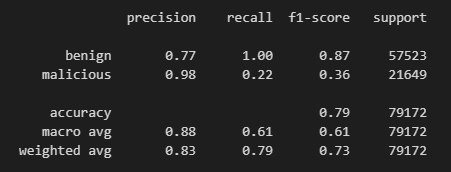

The model is actually worse, pretty much across the board

With just one feature, it is hard to really evaluate the model anyway, so lets introduce the _source_network_bytes and _source_event_duration as logged values, as it was found that a significant amount of malicious data could be encountered as outliers (specifically towards to lower range which would work particularly well for RBF which does calculations relative to origin (0,0))

In [71]:
df['_source_network_bytes_log'] = df['_source_network_bytes'].apply(lambda x: np.log(x) if x > 0 else 0)
df['_source_event_duration_log'] = df['_source_event_duration'].apply(lambda x: np.log(x) if x > 0 else 0)
mf_df = df[['_source_destination_port', '_source_network_bytes_log', '_source_event_duration_log', 'label']]
mf_df = mf_df.dropna()

Lets split the data once again for train/test

In [73]:
# Split df in benign/malicious
benign_mf_df = mf_df[mf_df['label'] == 'benign']
malicious_mf_df = mf_df[mf_df['label'] == 'malicious']

# Split benign into train/test
X_train, X_benign_test, y_train, y_benign_test = train_test_split(benign_mf_df[['_source_destination_port', '_source_network_bytes_log', '_source_event_duration_log']].values.reshape(-1, 3), benign_mf_df['label'], test_size=0.2, random_state=42)

# Add the malicious data back into the test split
X_test = np.vstack((X_benign_test, malicious_mf_df[['_source_destination_port', '_source_network_bytes_log', '_source_event_duration_log']].values.reshape(-1, 3)))
y_test = pd.concat([y_benign_test, malicious_mf_df['label']])

In [77]:
print(EvaluateSGDOneClassSVM(X_train, X_test, y_test))

              precision    recall  f1-score   support

      benign       0.41      1.00      0.58     57723
   malicious       0.99      0.22      0.36    107245

    accuracy                           0.49    164968
   macro avg       0.70      0.61      0.47    164968
weighted avg       0.79      0.49      0.43    164968



It suprisingly performed exactly the same as with just a single feature (only malicious precision is a single percentage lower)

For sanity, lets try it without the _source_destination_port, this could also indicate that the model is extremely overfitted/very generous with the nu value, as it did not seem to be able to establish any better indicator for malicious/benign

In [78]:
# Split df in benign/malicious
benign_mf_df = mf_df[mf_df['label'] == 'benign']
malicious_mf_df = mf_df[mf_df['label'] == 'malicious']

# Split benign into train/test
X_train, X_benign_test, y_train, y_benign_test = train_test_split(benign_mf_df[['_source_network_bytes_log', '_source_event_duration_log']].values.reshape(-1, 2), benign_mf_df['label'], test_size=0.2, random_state=42)

# Add the malicious data back into the test split
X_test = np.vstack((X_benign_test, malicious_mf_df[['_source_network_bytes_log', '_source_event_duration_log']].values.reshape(-1, 2)))
y_test = pd.concat([y_benign_test, malicious_mf_df['label']])

In [79]:
print(EvaluateSGDOneClassSVM(X_train, X_test, y_test))

              precision    recall  f1-score   support

      benign       0.56      0.95      0.71     57723
   malicious       0.96      0.60      0.74    107245

    accuracy                           0.72    164968
   macro avg       0.76      0.78      0.72    164968
weighted avg       0.82      0.72      0.73    164968



Interestingly, the results actually went up, indicating that the _source_destination_port was making the model's ability to identify outliers worse, as it was able to find more of the malicious data (60% vs 22%) while keeping the amount of true positives high (from 99% to 96%)

These results are still far from useable in accordance to the requirements from SUE, but it is a good indicator as the given model kernel is very limited (but very fast, which is why it was used for this initial trial), no hyperparameter tuning has been done, and this is only with two features

Out of curiousity, I have also tried it with the normal _source_network_bytes and _source_event_duration to see if the logging actually made a different, and it indeed did! without the log, the data is much more ubiquitous causing the model to not be able to create a well defined inlier/outlier split causing everything to be labeled as inliers

In [81]:
# Get the necessary features
mf_df = df[['_source_network_bytes', '_source_event_duration', 'label']]
mf_df = mf_df.dropna()

# Split df in benign/malicious
benign_mf_df = mf_df[mf_df['label'] == 'benign']
malicious_mf_df = mf_df[mf_df['label'] == 'malicious']

# Split benign into train/test
X_train, X_benign_test, y_train, y_benign_test = train_test_split(benign_mf_df[['_source_network_bytes', '_source_event_duration']].values.reshape(-1, 2), benign_mf_df['label'], test_size=0.2, random_state=42)

# Add the malicious data back into the test split
X_test = np.vstack((X_benign_test, malicious_mf_df[['_source_network_bytes', '_source_event_duration']].values.reshape(-1, 2)))
y_test = pd.concat([y_benign_test, malicious_mf_df['label']])

print(EvaluateSGDOneClassSVM(X_train, X_test, y_test))

c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      benign       0.35      1.00      0.52     58234
   malicious       0.00      0.00      0.00    107245

    accuracy                           0.35    165479
   macro avg       0.18      0.50      0.26    165479
weighted avg       0.12      0.35      0.18    165479



c:\Users\Sugar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Lets now try training a One-class SVM model with the RBF kernel, this training and evaluation will take significantly longer but is a much more commonly used kernel for One-class SVM

In [3]:
def EvaluateOneRBFClassSVM(train_data, test_data, test_labels, nu = 0.5):
    # Compile and train the model
    rbf_model = OneClassSVM(kernel="rbf", nu=nu, verbose=True)
    rbf_model.fit(train_data)
    # Test the model
    rbf_predictions = rbf_model.predict(test_data)
    rbf_predictions = ['benign' if pred == 1 else 'malicious' for pred in rbf_predictions] # By default, OneClassSVM will give -1 for outliers and 1 for inliers
    # Create a classification report
    return classification_report(test_labels, rbf_predictions, target_names=['benign', 'malicious'])


In [4]:
# Load the data
df = pd.read_csv('../data/elastic_february2022_data.csv')
# Get the necessary features
df['_source_network_bytes_log'] = df['_source_network_bytes'].apply(lambda x: np.log(x) if x > 0 else 0)
df['_source_event_duration_log'] = df['_source_event_duration'].apply(lambda x: np.log(x) if x > 0 else 0)
mf_df = df[['_source_network_bytes_log', '_source_event_duration_log', 'label']]
mf_df = mf_df.dropna()
# Split df in benign/malicious
benign_mf_df = mf_df[mf_df['label'] == 'benign']
malicious_mf_df = mf_df[mf_df['label'] == 'malicious']

# Split benign into train/test
X_train, X_benign_test, y_train, y_benign_test = train_test_split(benign_mf_df[['_source_network_bytes_log', '_source_event_duration_log']].values.reshape(-1, 2), benign_mf_df['label'], test_size=0.2, random_state=42)

# Add the malicious data back into the test split
X_test = np.vstack((X_benign_test, malicious_mf_df[['_source_network_bytes_log', '_source_event_duration_log']].values.reshape(-1, 2)))
y_test = pd.concat([y_benign_test, malicious_mf_df['label']])

In [5]:

print(EvaluateOneRBFClassSVM(X_train, X_test, y_test))

[LibSVM]              precision    recall  f1-score   support

      benign       0.80      0.50      0.61     58234
   malicious       0.77      0.93      0.85    107245

    accuracy                           0.78    165479
   macro avg       0.79      0.71      0.73    165479
weighted avg       0.78      0.78      0.76    165479



The results are very interesingly not directly better than the SGD model, however the precision vs recall trade-off has been skewed more towards spotting more of the malicious records at the cost of a lower accuracy of the spotted malicious data (higher false positives, but a also a higher rate of finding true positives).

While I did expect the RBF model to perform better due to the high adoption of the model and longer training time, the SGD model should not be overlooked just because it is significantly faster, as it was purpose built to be faster and more efficient than RBF.

Lets next take a look at the sigmoid kernel, which uses a form of logistic regression, this might also be good to train on the none logged features to see how logistic regression would handle it.

In [7]:
# Compile and train the model
sigmoid_model = OneClassSVM(kernel="sigmoid")
sigmoid_model.fit(X_train)
# Test the model
sigmoid_predictions = sigmoid_model.predict(X_test)
sigmoid_predictions = ['benign' if pred == 1 else 'malicious' for pred in sigmoid_predictions] # By default, OneClassSVM will give -1 for outliers and 1 for inliers
# Create a classification report
print(classification_report(y_test, sigmoid_predictions, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       1.00      0.50      0.67     58234
   malicious       0.79      1.00      0.88    107245

    accuracy                           0.82    165479
   macro avg       0.89      0.75      0.77    165479
weighted avg       0.86      0.82      0.81    165479



These results are better than RBF, which could make sense as RBF uses a radial basis function to create the separation radial for inliers and outliers, which might require the data to have a normal distribution which the features supplied do not have.

Lets also try sigmoid with the original data (non logged)

In [8]:
mf_df = df[['_source_network_bytes', '_source_event_duration', 'label']]
mf_df = mf_df.dropna()
# Split df in benign/malicious
benign_mf_df = mf_df[mf_df['label'] == 'benign']
malicious_mf_df = mf_df[mf_df['label'] == 'malicious']

# Split benign into train/test
X_train, X_benign_test, y_train, y_benign_test = train_test_split(benign_mf_df[['_source_network_bytes', '_source_event_duration']].values.reshape(-1, 2), benign_mf_df['label'], test_size=0.2, random_state=42)

# Add the malicious data back into the test split
X_test = np.vstack((X_benign_test, malicious_mf_df[['_source_network_bytes', '_source_event_duration']].values.reshape(-1, 2)))
y_test = pd.concat([y_benign_test, malicious_mf_df['label']])

# Compile and train the model
sigmoid_model = OneClassSVM(kernel="sigmoid")
sigmoid_model.fit(X_train)
# Test the model
sigmoid_predictions = sigmoid_model.predict(X_test)
sigmoid_predictions = ['benign' if pred == 1 else 'malicious' for pred in sigmoid_predictions] # By default, OneClassSVM will give -1 for outliers and 1 for inliers
# Create a classification report
print(classification_report(y_test, sigmoid_predictions, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       1.00      0.50      0.67     58234
   malicious       0.79      1.00      0.88    107245

    accuracy                           0.82    165479
   macro avg       0.89      0.75      0.77    165479
weighted avg       0.86      0.82      0.81    165479



The results are the same as before, proving that indeed the sigmoid function takes care of handling logarithmically distributed features

Now the recall for the benign data is very low, while the recall for malicious data is 100%, this could indicate that the model is being very leniant with marking records as outliers thereby over fitting too close around the benign (leaving benign datapoints outside of the inlier plane), this can be tweaked using the "nu" hyperparameter

Below I have tested the sigmoid kernel with a nu value of 0.4 and 0.6 with a lower value indicating less lenienty for outliers, which should increase the amount of records the model might identify as inliers and decrease the amount of outliers, as the area of inliers is increased (this is what we would want as currently the recall for outliers is 100% while inliers is only half)

In [6]:
def TestSigmoid(train_data, test_data, nu_parameter = 0.5):
    sigmoid_model = OneClassSVM(kernel="sigmoid", nu=nu_parameter)
    sigmoid_model.fit(train_data)
    sigmoid_predictions = sigmoid_model.predict(test_data)
    sigmoid_predictions = ['benign' if pred == 1 else 'malicious' for pred in sigmoid_predictions] # By default, OneClassSVM will give -1 for outliers and 1 for inliers
    return sigmoid_predictions

In [8]:
sigmoidLowNuResults = TestSigmoid(X_train, X_test, 0.4)
print(classification_report(y_test, sigmoidLowNuResults, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       1.00      0.60      0.75     58234
   malicious       0.82      1.00      0.90    107245

    accuracy                           0.86    165479
   macro avg       0.91      0.80      0.83    165479
weighted avg       0.88      0.86      0.85    165479



In [9]:
sigmoidHighNuResults = TestSigmoid(X_train, X_test, 0.6)
print(classification_report(y_test, sigmoidHighNuResults, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       1.00      0.40      0.57     58234
   malicious       0.75      1.00      0.86    107245

    accuracy                           0.79    165479
   macro avg       0.88      0.70      0.72    165479
weighted avg       0.84      0.79      0.76    165479



As expected, reducing the nu value increased the amount of benign records recalled by increasing the inlier range, while increasing the value decreased this inlier range, this would indicate that the default nu=0.5 used in most of these examples has been overfitting the model around the inliers which (quite unintuitively) makes the model favor outliers more

Lets create a confusion matrix for the better performing nu=0.4 model

Text(0.5, 1.0, 'Lower Nu score Sigmoid One-class SVM')

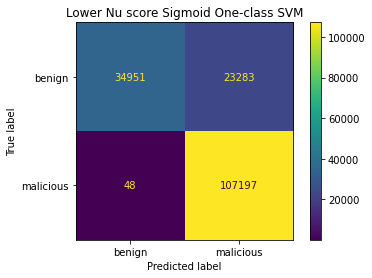

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, sigmoidLowNuResults)
matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malicious'])
matrix_display.plot()
plt.title("Lower Nu score Sigmoid One-class SVM")

Text(0.5, 1.0, 'Higher Nu score Sigmoid One-class SVM')

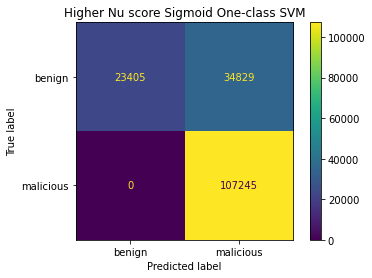

In [15]:
cm = confusion_matrix(y_test, sigmoidHighNuResults)
matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malicious'])
matrix_display.plot()
plt.title("Higher Nu score Sigmoid One-class SVM")

Looking at it visually shows the overfitting nature of increasing the nu value around the benign (inlier) datapoints, ensuring that it included no malicious (outliers) as benign (inliers), at the cost of leaving out some benign data within the inlier range

Coming back to the requirements of SUE, the model should be able to identify every* (99.99+%) of the benign data points, with the trade off of obtaining some false positives (benign labeled as malicious). However, it should be kept in mind that these standard records that we have been using here (unlike the flow records looked into during the second phase of data exploration) are received in large amounts every second, meaning that while accuracy might not be 99.99+% extra logic could be added to create a threshold of predicted malicious data points thereby avoiding possible wrongly predicted outliers, thereby increasing accuracy outside of the model itself.

**With the current model results, the sigmoid nu=0.4 model performs best, but there seems to be more headroom to be gained from tuning the hyper parameters further**

Out of interest, below a sigmoid model has been trained on nu=0.4 with every *default numerical feature available

In [25]:
mf_df = df[['_source_flow_final', '_source_network_bytes', '_source_event_duration', '_source_destination_port', '_source_source_port', 'label']]
mf_df = mf_df.dropna()
# Split df in benign/malicious
benign_mf_df = mf_df[mf_df['label'] == 'benign']
malicious_mf_df = mf_df[mf_df['label'] == 'malicious']

# Split benign into train/test
X_train, X_benign_test, y_train, y_benign_test = train_test_split(benign_mf_df[['_source_flow_final', '_source_network_bytes', '_source_event_duration', '_source_destination_port', '_source_source_port']].values.reshape(-1, 5), benign_mf_df['label'], test_size=0.2, random_state=42)

# Add the malicious data back into the test split
X_test = np.vstack((X_benign_test, malicious_mf_df[['_source_flow_final', '_source_network_bytes', '_source_event_duration', '_source_destination_port', '_source_source_port']].values.reshape(-1, 5)))
y_test = pd.concat([y_benign_test, malicious_mf_df['label']])

# Compile and train the model
sigmoid_full_feature_model = OneClassSVM(kernel="sigmoid", nu=0.4)
sigmoid_full_feature_model.fit(X_train)

OneClassSVM(kernel='sigmoid', nu=0.4)

In [27]:
sigmoid_full_feature_predictions = sigmoid_full_feature_model.predict(X_test)
sigmoid_full_feature_predictions = ['benign' if pred == 1 else 'malicious' for pred in sigmoid_full_feature_predictions]

In [28]:
print(classification_report(y_test, sigmoid_full_feature_predictions, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       1.00      0.60      0.75     57723
   malicious       0.82      1.00      0.90    107245

    accuracy                           0.86    164968
   macro avg       0.91      0.80      0.83    164968
weighted avg       0.88      0.86      0.85    164968



Text(0.5, 1.0, 'All numerical feature Sigmoid One-class SVM')

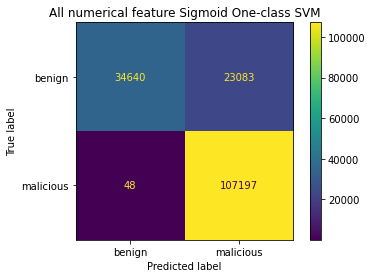

In [29]:
cm = confusion_matrix(y_test, sigmoid_full_feature_predictions)
matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malicious'])
matrix_display.plot()
plt.title("All numerical feature Sigmoid One-class SVM")

The model performs the exact same with all numerical features as just with two, this either indicates that the extra features do not help define a more optimal boundary or there is something wrong in the code steps causing the wrong results to be evaluated.